## 測試Clean Chinese HandWrite data 使用不同Classifier的預測結果

In [1]:
import glob
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
from  sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import preprocessing
random_state = 0

# 測試50個字

In [2]:
img_list = []
data_path = './clean_data/'
num_class = 50
#label dir 
folder_list = os.listdir(data_path)
folder_list.sort(key=lambda x: int(x))
for i in folder_list[:num_class]:
    im_list = os.listdir(data_path+i)
    for file in im_list:
        file_name = data_path+i+"/"+file
        img_list.append((file_name,int(i)))    
            

## Load Image

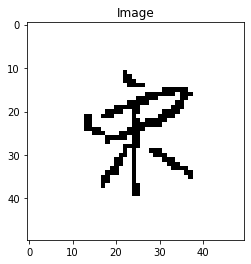

In [3]:
plt.title('Image')
plt.imshow(Image.open(img_list[0][0]),cmap='gray')

In [4]:
total_img = []
total_label = []
for file,label in img_list:
    img  = Image.open(file).convert('L').resize((50,50),Image.BILINEAR)
    total_label.append(label)
    total_img.append(np.array(img).reshape(-1))
total_img = np.array(total_img)
total_label = np.array(total_label)
print("Total label shape:",total_label.shape)
print("Total image shape:",total_img.shape)

Total label shape: (2641,)
Total image shape: (2641, 2500)


# Split train and test set

In [5]:
X_train,X_test,Y_train,Y_test = train_test_split(total_img,total_label,test_size=0.2,random_state=0)

X_train = preprocessing.scale(X_train)
X_test = X_train = preprocessing.scale(X_test)

# PCA explain ratio

Text(0, 0.5, 'cumulative explained variance')

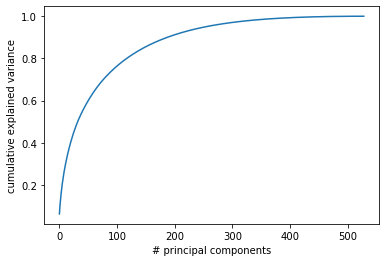

In [6]:
# 多少components 就可以代表0.95的資料
n_compons_rate = 0.95
pca = PCA()
pca.fit(X_train)
cum_explained_var_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cum_explained_var_ratio)
plt.xlabel('# principal components')
plt.ylabel('cumulative explained variance')

dim reduction one image

principle components shape: (6, 2500)


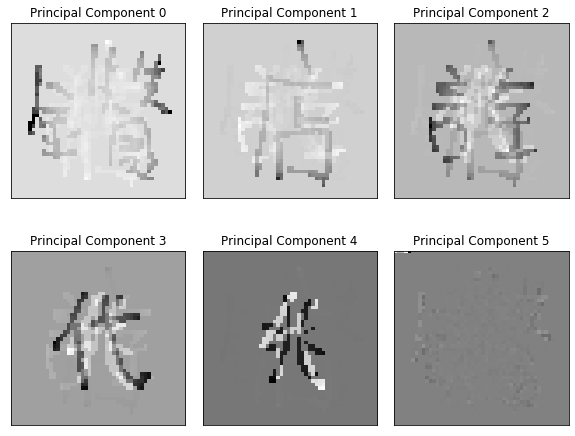

In [7]:
from sklearn.preprocessing import minmax_scale
pca = PCA()
trans_img = pca.fit_transform(X_train[:6])

scaled_comps = minmax_scale(pca.components_,axis=1)
print("principle components shape:",pca.components_.shape)
fig,axes = plt.subplots(2,3,figsize=(10,8),
                        subplot_kw = {"xticks":[],'yticks':[]},
                        gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    c = scaled_comps[i]
    ax.set_title('Principal Component '+str(i))
    ax.imshow(c.reshape(50,50),cmap='gray')


# predict function

In [8]:
def predict_accuracy(y, y_hat):
    return sum(y == y_hat) / y.shape[0]

## PCA components數 影響 SVM accuracy

In [9]:
def differ_components_SVM(X_train,Y_train,X_test,Y_test,):
    best_acc = 0
    best_rate = 100
    for i in range(90,0,-10):
        pca = PCA(i/100,random_state=random_state)
        pipe = make_pipeline(StandardScaler(),pca)
        transformed_images = pca.fit_transform(X_train)
    #     print("transformed_images.shape:",transformed_images.shape)
        transform_test = pca.transform(X_test)
        clf = svm.SVC()
        clf.fit(transformed_images,Y_train)
        res = clf.predict(transform_test)
        acc = predict_accuracy(res,Y_test)
        if best_acc<acc:
            best_acc = acc
            best_rate = i/100
        
        print("{} components accuracy:{:.2%}".format(pca.components_.shape[0],acc))
    print("Best accuracy:{:.2%} , Best component rate:{}".format(best_acc,best_rate))


In [10]:
differ_components_SVM(X_train,Y_train,X_test,Y_test)

ValueError: Found input variables with inconsistent numbers of samples: [529, 2112]

## PCA

In [ ]:
pca = PCA(0.9,random_state=random_state)
pipe = make_pipeline(StandardScaler(),pca)
pca.fit(X_train)

transformed_train = pca.transform(X_train)
transformed_test = pca.transform(X_test)

print('-----PCA dimension reduction----')
print("transformed train images.shape:",transformed_train.shape)
print("transformed test  images.shape:",transformed_test.shape)


In [11]:
reconstruct_image = pca.inverse_transform(transformed_train)
reconstruct_image = reconstruct_image.reshape((reconstruct_image.shape[0],50,50)).astype(np.uint8)
img_pca = Image.fromarray(reconstruct_image[10] ,'L')
print("components_number:",pca.components_.shape[0])
plt.subplot(2,2,1)
plt.title('PCA reconstruct-image')
plt.imshow(img_pca,cmap='gray')
plt.subplot(2,2,2)
plt.title('Original img')
plt.imshow(Image.fromarray(X_train[10].reshape(50,50) ,'L'),cmap='gray')
plt.show()


NameError: name 'transformed_train' is not defined

## PCA reconstruct Image

components_number: 255
components_number: 148
components_number: 96
components_number: 63
components_number: 41
components_number: 26
components_number: 16
components_number: 9
components_number: 4
components_number: 1


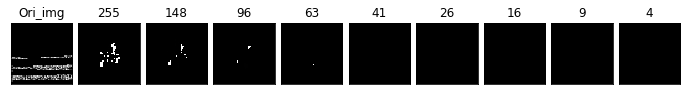

In [12]:
def diff_component_reconstruct(X_train,X_test,k):
    diff_reconstruct=[]
    diff_reconstruct.append((Image.fromarray(X_train[k].reshape(50,50) ,'L'),"Ori_img"))

    for i in range(95,0,-10):
        pca = PCA(i/100,random_state=random_state)
        pipe = make_pipeline(StandardScaler(),pca)
        pca.fit(X_train)
        transformed_train = pca.transform(X_train)
        transformed_test = pca.transform(X_test)


        reconstruct_image = pca.inverse_transform(transformed_train)
        reconstruct_image = reconstruct_image.reshape((reconstruct_image.shape[0],50,50)).astype(np.uint8)
        img_pca = Image.fromarray(reconstruct_image[k],'L')
        print("components_number:",pca.components_.shape[0])
        diff_reconstruct.append((img_pca,pca.components_.shape[0]))
    fig, axes = plt.subplots(1,10, figsize=(12, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        

        img_pca = diff_reconstruct[i][0]
        ax.set_title(diff_reconstruct[i][1])
        ax.imshow(img_pca,cmap='gray')
       
   
diff_component_reconstruct(X_train,X_test,k=10)

NameError: name 'transformed_train' is not defined

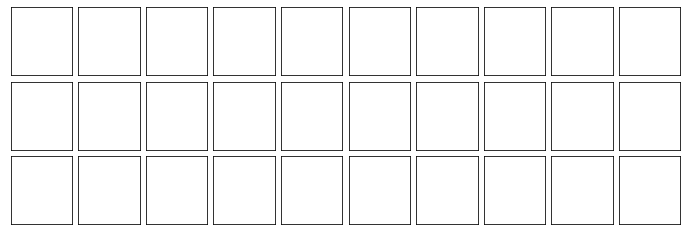

In [13]:
fig, axes = plt.subplots(3,10, figsize=(12, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

reconstruct_image = pca.inverse_transform(transformed_train)
reconstruct_image = reconstruct_image.reshape((reconstruct_image.shape[0],50,50)).astype(np.uint8)
for i, ax in enumerate(axes.flat):
        img_pca = Image.fromarray(reconstruct_image[i] ,'L')
        ax.imshow(img_pca,cmap='gray')

# LDA

In [ ]:
def LDA(X_train,Y_train,X_test,Y_test):
    lda = LinearDiscriminantAnalysis(solver='svd')
    lda = make_pipeline(StandardScaler(),lda)
    lda.fit(X_train,Y_train)
    transform_images = lda.transform(X_train)
    transform_test = lda.transform(X_test)
    return transform_images,transform_test
lda_train,lda_test = LDA(X_train,Y_train,X_test,Y_test)

# SVM 

In [114]:
def SVM(X_train,Y_train,X_test,Y_test):
    clf = svm.SVC(random_state=random_state)
    clf.fit(X_train,Y_train)
    res = clf.predict(X_test)
    return predict_accuracy(res,Y_test)
print("PCA+SVM:{}".format(SVM(transformed_train,Y_train,transformed_test,Y_test))) 
print("LDA+SVM:{}".format(SVM(lda_train,Y_train,lda_test,Y_test)))

PCA+SVM:0.7466918714555766
LDA+SVM:0.28166351606805295


# Perceptron

In [64]:
from sklearn.linear_model import Perceptron

In [80]:
clf = make_pipeline(StandardScaler(),Perceptron(tol=1e-5,random_state=random_state))
clf.fit(transformed_train,Y_train)
clf.score(transformed_train,Y_train)
clf.score(transformed_test,Y_test)

0.42722117202268434

# MLP

In [113]:
def MLP(X_train,Y_train,X_test,Y_test,hidden_layer):
    max_iter = 5000
    clf = MLPClassifier(hidden_layer_sizes=hidden_layer,solver='adam',activation='relu',learning_rate='adaptive',max_iter=max_iter,random_state=random_state)
    clf.fit(X_train,Y_train)
    res = clf.predict(X_test)
    print("{} iter accuracy:{}".format(max_iter,predict_accuracy(res,Y_test)))
    return predict_accuracy(res,Y_test)

hidden_size = (100,3)
MLP(transformed_train,Y_train,transformed_test,Y_test,hidden_size)

5000 iter accuracy:0.03780718336483932


0.03780718336483932

In [110]:
max_iter = 5000
hidden_layer = (512,512,64)
print("MLP with different components")
for i in range(90,40,-10):
    pca = PCA(i/100,random_state=random_state)
    pipe = make_pipeline(StandardScaler(),pca)
    transform_images = pipe.fit_transform(X_train)
    transform_test = pipe.transform(X_test)
    clf = MLPClassifier(hidden_layer_sizes=2500,max_iter=max_iter,random_state=random_state)
    clf.fit(transform_images,Y_train)
    res = clf.predict(transform_test)
    acc = predict_accuracy(res,Y_test)
    print("{} components accuracy:{:.2%}".format(pca.components_.shape[0],acc))

MLP with different components


/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


379 components accuracy:72.97%
233 components accuracy:74.86%
153 components accuracy:75.80%
100 components accuracy:77.88%
63 components accuracy:72.78%


# LDA

In [18]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [19]:
def LDA(X_train,Y_train,X_test,Y_test):
    lda = LinearDiscriminantAnalysis(solver='svd')
    pipe = make_pipeline(StandardScaler(),lda)
    lda.fit(X_train,Y_train)
    transform_images = lda.transform(X_train)
    transform_test = lda.transform(X_test)
    return transform_images,transform_test
    
    


In [20]:
lda_train,lda_test = LDA(X_train,Y_train,X_test,Y_test)